<h1 align = center> <b> Reinforcement Learning (M2 MOSIG / MSIAM)<h1>

<h1 align = center>  Lab 1: Dynamic Programming - Value Iteration and Policy Iteration<h1>


## Introduction

The purpose of this lab is to introduce the classical concept of *Bellman equations* and two dynamic-programming algorithms---*value iteration* and *policy iteration* in MDP.
$
\newcommand{\vs}[1]{\mathbf{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\mathbf{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\U{V}
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\prob{\mathbb{P}}       % action
\def\actionset{\mathcal{A}} %%%
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
%
\def\E{\mathbb{E}}
%\newcommand{transition}{T(s,a,s')}
%\newcommand{transitionfunc}{\mathcal{T}^a_{ss'}}
\newcommand{transitionfunc}{P}
\newcommand{transitionfuncinst}{P(\nextstate|\state,\action)}
\newcommand{transitionfuncpi}{\mathcal{T}^{\pi_i(s)}_{ss'}}
\newcommand{rewardfunc}{r}
\newcommand{rewardfuncinst}{r(\state,\action,\nextstate)}
\newcommand{rewardfuncpi}{r(s,\pi_i(s),s')}
\newcommand{statespace}{\mathcal{S}}
\newcommand{statespaceterm}{\mathcal{S}^F}
\newcommand{statespacefull}{\mathcal{S^+}}
\newcommand{actionspace}{\mathcal{A}}
\newcommand{reward}{R}
\newcommand{statet}{S}
\newcommand{actiont}{A}
%\newcommand{newstatet}{S'}
\newcommand{nextstate}{\state'}
\newcommand{newactiont}{A'}
\newcommand{stepsize}{\alpha}
\newcommand{discount}{\gamma}
\newcommand{qtable}{q_*}
\newcommand{finalstate}{\state_F}
%
\newcommand{\vs}[1]{\boldsymbol{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\boldsymbol{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\vit{Value Iteration}
\def\pit{Policy Iteration}
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
\def\cstateset{\mathcal{X}} %%%
\def\x{\vs{x}}                    % TODO cstate
\def\cstate{\vs{x}}               %%%
\def\policy{\pi}
\def\piparam{\vs{\theta}}         % TODO pparam
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\caction{\vs{u}}       % action
\def\cactionset{\mathcal{U}} %%%
\def\decision{\vs{d}}       % decision
\def\randvar{\vs{\omega}}       %%%
\def\randset{\Omega}       %%%
\def\transition{T}       %%%
\def\immediatereward{r}    %%%
\def\strategichorizon{s}    %%% % TODO
\def\tacticalhorizon{k}    %%%  % TODO
\def\operationalhorizon{h}    %%%
\def\constalpha{a}    %%%
\def\U{V}              % utility function
\def\valuefunc{V}
\def\X{\mathcal{X}}
\def\meu{Maximum Expected Utility}
\def\finaltime{T}
\def\timeindex{t}
\def\iterationindex{i}
\def\decisionfunc{d}       % action
\def\mdp{\text{MDP}}
$

**Notice**: this notebook requires the following libraries: OpenAI *Gym*, NumPy, Pandas and Seaborn. There are two options:

  * If you want to run this notebook in your local machine, you can install them with the following command (and ignore the next cell):

``
pip install gym numpy pandas seaborn
``

  * Alternatively, if you want to run this notebook on Google Colab, just run the next cell. 

In [10]:
colab_requirements = ["gym", "numpy","pandas","seaborn"]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math
import gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns
sns.set_context("talk")  #Set-up context of seaborn with scaled parameters of notebook

## 0. Markov Decision Process (recalled):



* An **MDP** is defined by:
  * $\statespace$ state space
  * $\actionspace$ action space
  * Transision probability and induced reward: $\prob(\state^{\prime}, \reward | \state, \action)$ for all states & actions

* **State-dependant Reward**: In this lab, we only consider MDPs where the reward **only** depends on the state, i.e., each state $\state$ has a reward $\reward(\state)$ (regardless of actions leading to that state). 


* A (deterministic) **policy**: $\policy: \statespace \rightarrow \actionspace$. A stochastic policy: $\policy : \statespace \times \actionspace \rightarrow [0,1]$.

* **Key objective:** To look for the *best* policy, i.e., the policy maximizes the *expected discouted reward* (starting from time $t$):

 $\mathbb{E}[G_t] := \mathbb{E} \left[ \sum_{k=0}^{\infty} \discount^{k} \reward_{t+k+1}\right]  $.

## 1. Value Iteration

* The Value Function:
  * The state value function w.r.t. a policy $\policy$:

  $$
  \U^{\pi}(\state) = \mathbb{E} \left[ \sum^{\infty}_{t=0} \discount^t \reward(\state_t) | \pi, \state_0 = \state \right].
  $$
  * The **optimal value** at a state $\state$ is $\U^*(\state) = \max_{\policy} \U^{\policy} (\state)$

  * *The most important thing of this lecture:* The **Bellman Equation**:
  $$
  \U^*(s) = \max_{\action} \sum_{\state^{\prime}} \prob(\state^{\prime} | \state, \action) \left[ \reward(\state^{\prime}) + \discount \U^*(\state^{\prime}) \right]
  $$
  * Road-map of this section:

  <center> Value Iteration $\xrightarrow[]{\text{quickly estimates}} \U^* \xrightarrow[]{\text{deduces}} \text{ optimal policy } \policy^*$ <center>

> **Value Iteration Algorithm:** 
  * Basic idea: turn the bellman equation into an update rule:
    \begin{equation}
      \U_{k+1}(\state) := \left\{
          \begin{array}{l l}
              r(\state)    & \quad \text{if $\state$ is a final state} \\
              \displaystyle r(\state) + \discount \max_{\action \in \actionset} \left[ \sum_{\state' \in \stateset} \prob(\state' | \state, \action) \U_{k}(\state') \right]    & \quad \text{otherwise}\\
          \end{array} \right.
    \end{equation}
    
   * Convergence of Value Iteration (informal) [Puterman'1994]: 
   
   If $\|\U_{k} -\U_{k-1} \| < \varepsilon(1-\discount)/\discount$, then $\| \U^* - \U_k \| < \varepsilon$. 

  Therefore, we set the **stopping criterior**: $\delta < \varepsilon(1-\gamma)/\gamma$ where  $\delta := \|\U_{k} - \U_{k-1} \|_{\infty} = \max_{\state}|\U_{k}(\state) - \U_{k-1}(\state)  | $.

## 2. OpenAI Gym and the FrozenLake toy problem

For the purpose of focusing on the algorithms, we will use standard environments provided by OpenAI Gym framework (https://gym.openai.com/envs/). In this lab, we focus on the FrozenLake-v0 environment (https://gym.openai.com/envs/FrozenLake-v0/). Additional information is available [here](https://github.com/openai/gym/wiki/FrozenLake-v0) and [here](https://github.com/openai/gym/wiki/FrozenLake-v0).

**Notice**: this environment is *fully observable*, i.e., the learning agent knows all the state and transition in advance. 

### The FrozenLake Environment and Syntax

In [12]:
## Load the FrozenLake environment, its states and actions:
env = gym.make('FrozenLake-v1')
states = list(range(env.observation_space.n))
actions = list(range(env.action_space.n))

For a simpler syntax, run the next cell to define several usel arrays:

In [13]:

is_final_array = np.full(shape=len(states), fill_value=np.nan, dtype=np.bool)
reward_array = np.full(shape=len(states), fill_value=np.NINF)                # np.NINF = negative infinity
transition_array = np.zeros(shape=(len(states), len(actions), len(states)))
for state in states:
    for action in actions:
        for next_state_tuple in env.P[state][action]:              # env.P[state][action] contains the next states list (a list of tuples)
            transition_probability, next_state, next_state_reward, next_state_is_final = next_state_tuple

            is_final_array[next_state] = next_state_is_final
            reward_array[next_state] = max(reward_array[next_state], next_state_reward)   # workaround: when we already are in state 15, reward is 0 if we stay in state 15 (in practice this never append as the simulation stop when we arrive in state 15 as any other terminal state)
            transition_array[state, action, next_state] += transition_probability

action_labels = {
    0: "Move Left",
    1: "Move Down",
    2: "Move Right",
    3: "Move Up"
}

# For visualizing the environment
try: env.render()
except:pass # render not available


print('\n', 'states: ', states)
print('actions:', actions)
print('action name convetion', action_labels)
print('Reward:' ,reward_array)
print('Is final state:', is_final_array)



SFFF
FHFH
FFFH
HFFG

 states:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
actions: [0, 1, 2, 3]
action name convetion {0: 'Move Left', 1: 'Move Down', 2: 'Move Right', 3: 'Move Up'}
Reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Is final state: [False False False False False  True False  True False False False  True
  True False False  True]


* Notice: To recall the actions name convention, run ```action_labels```.

**Transision probability:** 
<img src="https://raw.githubusercontent.com/dongquan-vu/teaching/main/FrozenLake_trans.PNG" style="float: left; width: 150%" />


In [14]:
# SYNTAX: transition_array[state, action, next_state]
# For example, we check the transision probability from a state s=6 to a state s'=10 when chosing action a = 1 (moving down):
transition_array[4,3,0]

0.3333333333333333

For a better visual illustration, run the next cell:

In [15]:
def states_display(state_seq, title=None, figsize=(5,5), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds"):
    size = int(math.sqrt(len(state_seq)))
    state_array = np.array(state_seq)
    state_array = state_array.reshape(size, size)
    
    fig, ax = plt.subplots(figsize=figsize)         # Sample figsize in inches
    sns.heatmap(state_array, annot=annot, fmt=fmt, linewidths=linewidths, square=square, cbar=cbar, cmap=cmap)
    plt.title(title)
    plt.show()
def transition_display(state, action):
  states_display(transition_array[state,action], title="Transition probabilities for action {} ({}) in state {}".format(action, action_labels[action], state))

def display_policy(policy):
    actions_src = ["{}={}".format(action, action_labels[action].replace("Move ", "")) for action in actions]
    title = "Policy (" + ", ".join(actions_src) + ")"
    states_display(policy, title=title, fmt="d", cbar=False, cmap="Reds")

def reachable_states(state, action):
    return np.nonzero(transition_array[state, action])[0]


In [16]:
transition_display(state=14,action = )

SyntaxError: invalid syntax (<ipython-input-16-8eb7e5db2e47>, line 1)

## Exercise 1: Implement the Value Iteration algorithm

To implement Value Iteration, you will need the transition probability (or the transition function) defined in `transition_array`.
- Use `reachable_states(S, A)` to get the list of reachable states from state `S` executing action `A`.
- Use `transition_array[S, A]` to get the probability of reaching each state from state `S` executing action `A`.
- Use `transition_array[S, A, S']` to get the probability of reaching state `S'` from state `S` executing action `A`.

You will also need the previously defined `is_final_array` matrix.
- Use `is_final_array[S]` to know whether `S` is a final state (`True`) or not (`False`).

Finally, you will need the previously defined `reward_array` matrix.
- Use `reward_array[S]` to get the reward obtained by the agent each time it reaches state `S`.

In the following cell, we define `expected_value` and `expected_values` functions for convenience.
The first one returns the expected reward
$$\sum_{\state^{\prime}} P(\state' | \state, \action) \U(\state')$$
for a given pair $(\state, \action)$ and a given V-table (value function) $\U$.
The second one computes the expected reward for all the actions in $\state$.

In [ ]:
def expected_value(state, action, v_array):
    return (transition_array[state, action] * v_array).sum() # compute sum(P(s'|a,s').V(s'))

In [ ]:
transition_array.shape

In [55]:
def expected_values(state, v_array):
    return (transition_array[state] * v_array).sum(axis=1)   # compute sum(P(s'|a,s).V(s')) for all the actions

### Question 1: Implement the Value Iteration algorithm (compute the *value function* `v_array`)

**Note**: here we use the `state_display` function to show the evolution of the value function `v_array` over iterations.

In [84]:
stop = False

value_function_history = []
delta_history = []

def value_iteration(gamma=0.95, epsilon=0.1, display=False):
    v_array = np.zeros(len(states))   # Initial value function
    stop = False

    while not stop:
        # For displaying the v_array if display ==True
        if display==True: 
          states_display(v_array, title="Value function", cbar=True, cmap="Reds")
          print('V_array=',v_array)
        else: print('.', end="")

        ### To store the value_function_history
        value_function_history.append(v_array.copy())
        # Initialize the delta value
        delta = 0
        
       
        #################
        # FILLING IN THE BLANK HERE: 
        # You need to update the value of each state via Bellman-update. Then, update the value of delta (for checking the stopping criterior)
        for s in states:
            
            if is_final_array[s]:
                v_array[s] = reward_array[s] #pas de somme car final state = trou => je bouge plus ie ep termination
               
            else:                
                v_array[s] = reward_array[s]+gamma*max(expected_values(s, v_array))
                            # je retiens l'action qui maximise le exp_value = reward*value_array de tous les états
                            # somehow = I measure the reward I get when I go from state S to other states exec 4 act
        delta = max(abs(v_array-value_function_history[-1]))
              
                
        ###################################
        # save the delta value for plotting purpose 
        delta_history.append(delta)
        
        if delta < epsilon*(1-gamma)/gamma:
            stop = True
    
    return v_array
        

Now, we run the value iteration algorithm and store the result into ```v_array```.

Bonus question: Try to see the evolution of the state-values; does this match your intuition?


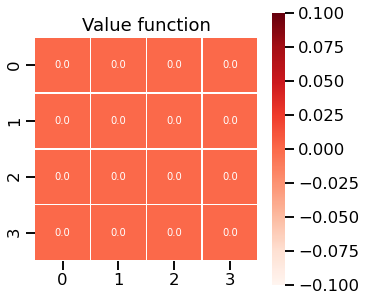

V_array= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


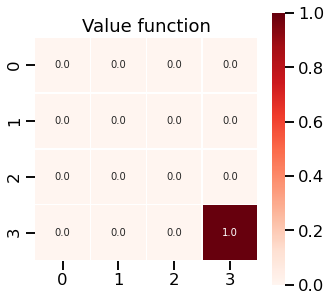

V_array= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


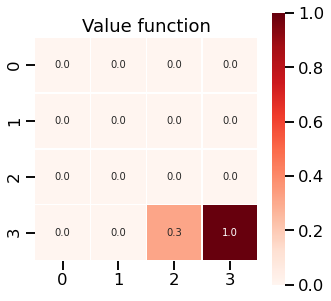

V_array= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.31666667 1.        ]


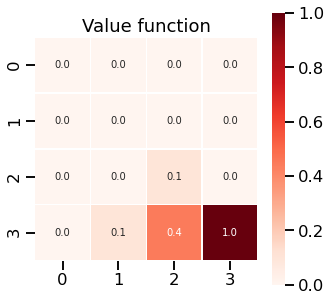

V_array= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.10027778 0.
 0.         0.10027778 0.44869907 1.        ]


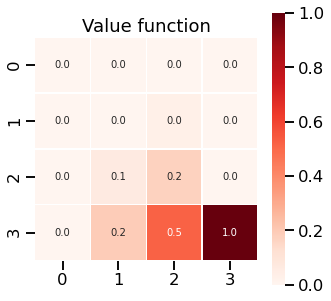

V_array= [0.         0.         0.         0.         0.         0.
 0.03175463 0.         0.         0.06350926 0.17225494 0.
 0.         0.19395394 0.52017345 1.        ]


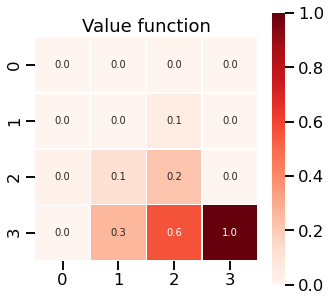

V_array= [0.         0.         0.01005563 0.00318428 0.         0.
 0.05773168 0.         0.02011127 0.12233471 0.22174262 0.
 0.         0.26487966 0.56526682 1.        ]


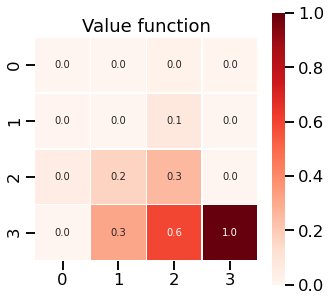

V_array= [0.         0.00318428 0.02247434 0.00913359 0.00636857 0.
 0.07733537 0.         0.04712461 0.16901985 0.25701365 0.
 0.         0.31640267 0.59586201 1.        ]


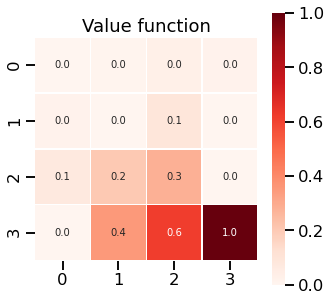

V_array= [0.00302507 0.00908317 0.03449871 0.0167092  0.01789744 0.
 0.09231225 0.         0.07411327 0.20505104 0.28285467 0.
 0.         0.35381664 0.61739824 1.        ]


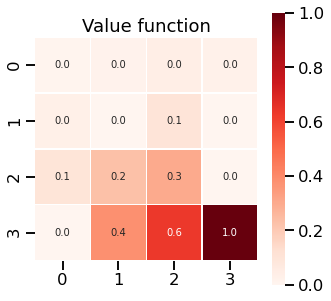

V_array= [0.0095018  0.01680983 0.04547992 0.02498446 0.03214563 0.
 0.10397262 0.         0.09858148 0.23283005 0.30216362 0.
 0.         0.3812809  0.63291506 1.        ]


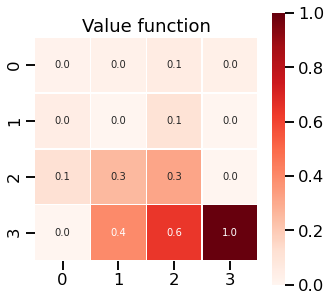

V_array= [0.01851147 0.02558705 0.0554292  0.03337608 0.04725888 0.
 0.11323773 0.         0.1199123  0.25439632 0.31684055 0.
 0.         0.40172089 0.64430138 1.        ]


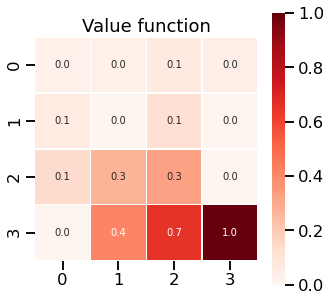

V_array= [0.02892984 0.03481626 0.06443634 0.04154302 0.06209866 0.
 0.12073768 0.         0.13819564 0.27130641 0.32817607 0.
 0.         0.41715408 0.65279423 1.        ]


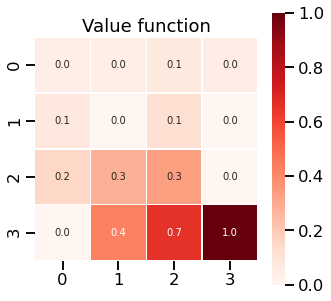

V_array= [0.03985084 0.04404943 0.07258743 0.0492966  0.07604596 0.
 0.12690844 0.         0.15375687 0.28471089 0.33706429 0.
 0.         0.42897541 0.65922705 1.        ]


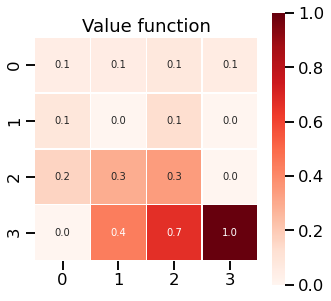

V_array= [0.05064964 0.05297406 0.07994881 0.0565383  0.08880995 0.
 0.13205415 0.         0.16697127 0.29545348 0.34413265 0.
 0.         0.43815772 0.66417184 1.        ]


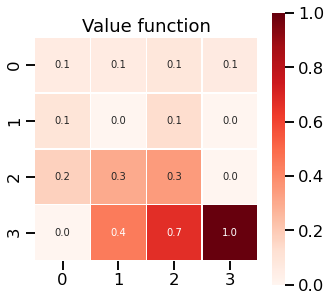

V_array= [0.06093732 0.06138906 0.08657414 0.06322274 0.1002942  0.
 0.13639048 0.         0.17819434 0.30415349 0.34982667 0.
 0.         0.4453863  0.66802675 1.        ]


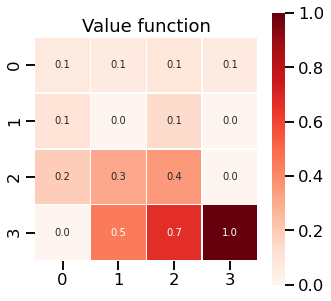

V_array= [0.07049652 0.06917891 0.09251212 0.06933657 0.11051194 0.
 0.14007395 0.         0.18773892 0.3112681  0.35446679 0.
 0.         0.45114903 0.67107233 1.        ]


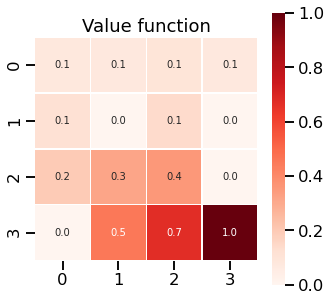

V_array= [0.07964324 0.07642252 0.09785272 0.07489986 0.11966646 0.
 0.14323451 0.         0.19591327 0.31715088 0.35829494 0.
 0.         0.45580121 0.67350995 1.        ]


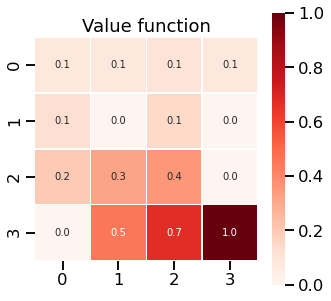

V_array= [0.0883351  0.08315994 0.10267827 0.07995136 0.12790636 0.
 0.14597485 0.         0.202974   0.32207221 0.36149306 0.
 0.         0.45960474 0.67548632 1.        ]


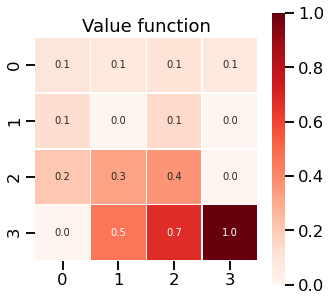

V_array= [0.09644925 0.08939103 0.10704731 0.08453418 0.13532104 0.
 0.14837112 0.         0.2091163  0.32623446 0.36419577 0.
 0.         0.46275308 0.67710914 1.        ]


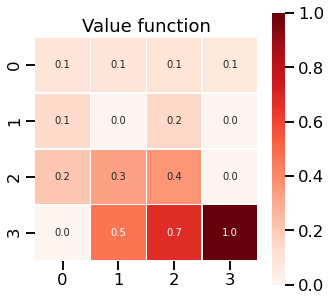

V_array= [0.10393619 0.0951186  0.11100339 0.08868939 0.14198495 0.
 0.15047973 0.         0.21448964 0.32978885 0.36650295 0.
 0.         0.46538951 0.67845791 1.        ]


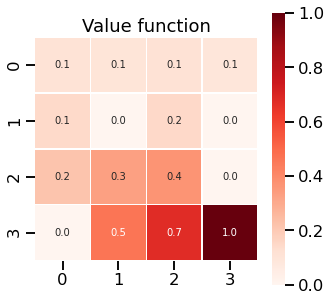

V_array= [0.11078815 0.10035488 0.11458204 0.09245426 0.14796653 0.
 0.15234358 0.         0.21921093 0.3328494  0.36848945 0.
 0.         0.46762066 0.67959155 1.        ]


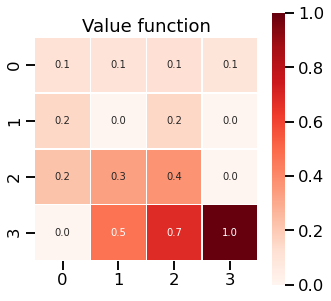

V_array= [0.1170219  0.10512029 0.11781454 0.0958623  0.1533298  0.
 0.15399626 0.         0.22337354 0.33550315 0.37021214 0.
 0.         0.46952653 0.68055406 1.        ]


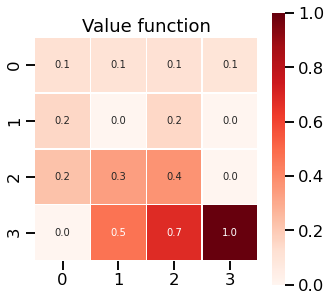

V_array= [0.1226683  0.10944099 0.12072973 0.09894387 0.15813435 0.
 0.15546493 0.         0.2270535  0.33781752 0.37171489 0.
 0.         0.47116773 0.68137857 1.        ]


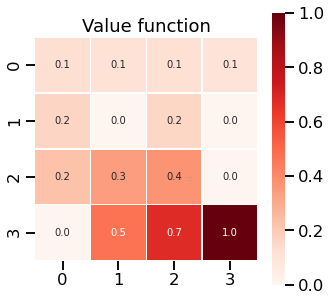

V_array= [0.1277658  0.11334657 0.12335472 0.10172678 0.16243532 0.
 0.15677204 0.         0.23031368 0.3398455  0.3730321  0.
 0.         0.47259074 0.68209028 1.        ]


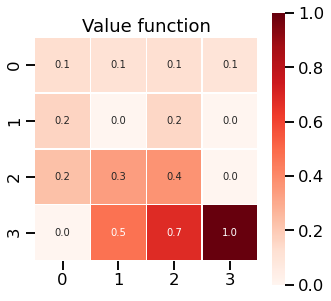

V_array= [0.1323562  0.1168682  0.12571507 0.10423673 0.16628331 0.
 0.15793661 0.         0.23320679 0.34162938 0.37419115 0.
 0.         0.47383163 0.6827086  1.        ]


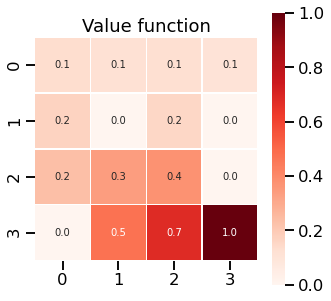

V_array= [0.13648197 0.12003733 0.12783485 0.10649764 0.16972449 0.
 0.1589749  0.         0.23577754 0.34320343 0.3752142  0.
 0.         0.47491883 0.68324869 1.        ]


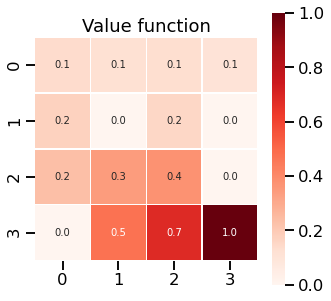

V_array= [0.14018467 0.12288467 0.12973657 0.10853175 0.17280079 0.
 0.15990108 0.         0.23806423 0.3445958  0.37611943 0.
 0.         0.47587505 0.68372252 1.        ]


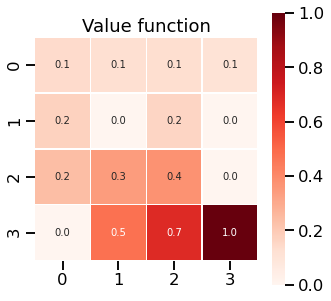

V_array= [0.14350387 0.12543962 0.13144113 0.1103598  0.17555015 0.
 0.16072751 0.         0.24009989 0.34582988 0.37692197 0.
 0.         0.47671869 0.68413972 1.        ]


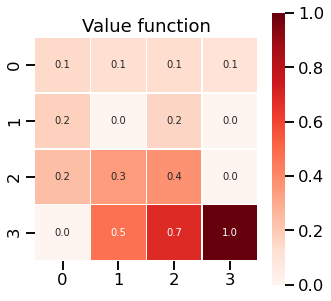

V_array= [0.14647667 0.12772985 0.13296786 0.11200103 0.17800679 0.
 0.16146511 0.         0.24191324 0.3469254  0.37763457 0.
 0.         0.47746487 0.68450812 1.        ]


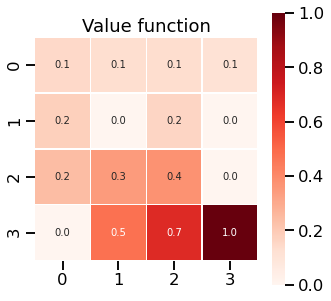

V_array= [0.14913737 0.12978111 0.13433446 0.11347323 0.18020151 0.
 0.16212353 0.         0.24352938 0.34789913 0.37826808 0.
 0.         0.47812617 0.68483419 1.        ]


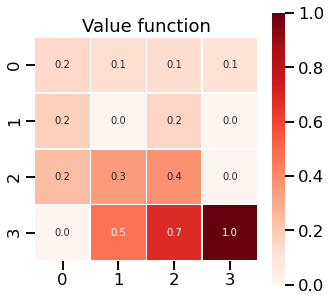

V_array= [0.15151748 0.13161713 0.13555712 0.1147928  0.18216199 0.
 0.16271131 0.         0.24497032 0.34876545 0.3788318  0.
 0.         0.47871317 0.68512333 1.        ]


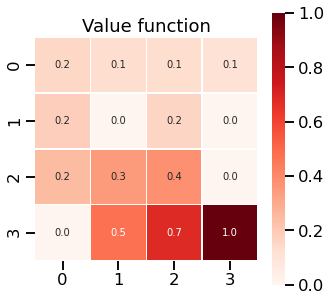

V_array= [0.1536457  0.13325965 0.13665056 0.11597478 0.18391304 0.
 0.16323608 0.         0.24625546 0.3495368  0.3793338  0.
 0.         0.47923488 0.6853801  1.        ]


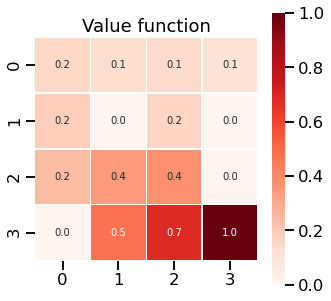

V_array= [0.15554807 0.13472846 0.13762811 0.11703293 0.18547691 0.
 0.16370461 0.         0.2474019  0.35022402 0.3797811  0.
 0.         0.47969902 0.68560839 1.        ]


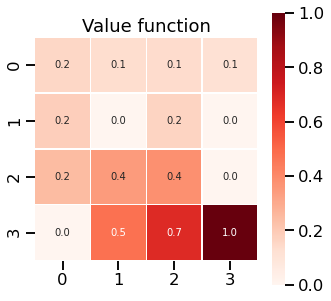

V_array= [0.15724813 0.13604149 0.13850183 0.11797977 0.18687353 0.
 0.16412293 0.         0.24842483 0.35083657 0.38017983 0.
 0.         0.48011226 0.68581154 1.        ]


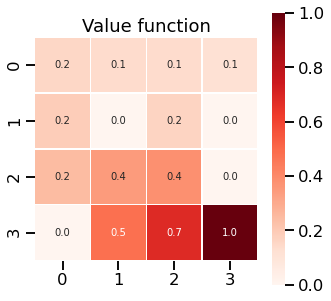

V_array= [0.1587671  0.13721497 0.13928258 0.11882667 0.18812073 0.
 0.16449643 0.         0.24933767 0.35138276 0.3805354  0.
 0.         0.48048041 0.68599245 1.        ]


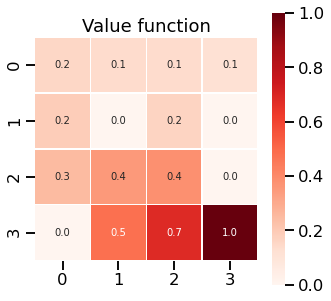

V_array= [0.16012406 0.13826351 0.13998013 0.11958393 0.18923445 0.
 0.16482992 0.         0.25015238 0.35186992 0.38085256 0.
 0.         0.48080855 0.68615365 1.        ]


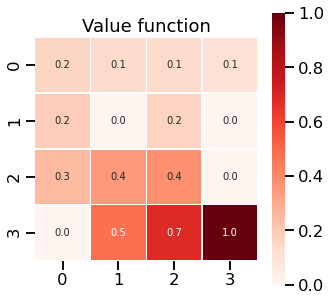

V_array= [0.16133615 0.13920027 0.14060327 0.12026086 0.19022894 0.
 0.16512768 0.         0.25087956 0.35230454 0.38113553 0.
 0.         0.48110113 0.68629735 1.        ]


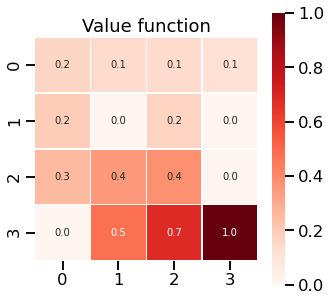

V_array= [0.16241873 0.14003705 0.14115986 0.12086584 0.19111696 0.
 0.16539354 0.         0.25152867 0.35269235 0.38138803 0.
 0.         0.4813621  0.68642549 1.        ]


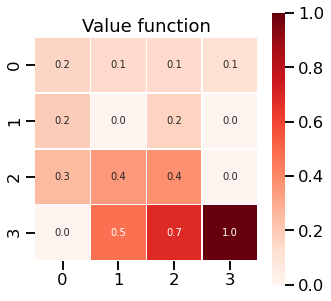

V_array= [0.16338556 0.14078445 0.14165699 0.12140641 0.19190988 0.
 0.16563092 0.         0.25210812 0.35303844 0.38161337 0.
 0.         0.48159491 0.68653979 1.        ]


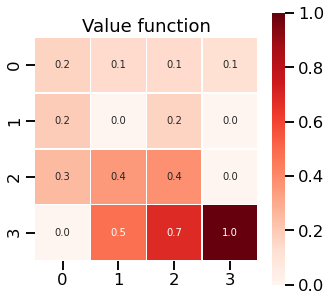

V_array= [0.16424898 0.14145197 0.14210096 0.12188936 0.19261788 0.
 0.16584287 0.         0.25262541 0.35334733 0.3818145  0.
 0.         0.48180265 0.68664177 1.        ]


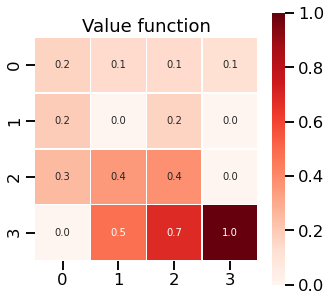

V_array= [0.16502002 0.1420481  0.14249745 0.12232079 0.19325004 0.
 0.16603212 0.         0.25308722 0.35362305 0.38199403 0.
 0.         0.48198803 0.68673277 1.        ]


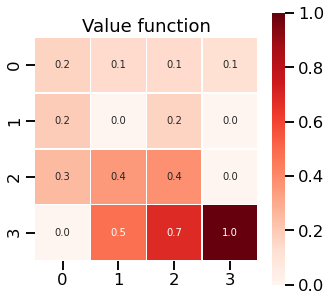

V_array= [0.16570853 0.14258046 0.14285151 0.12270614 0.1938145  0.
 0.16620109 0.         0.25349951 0.35386916 0.38215429 0.
 0.         0.48215349 0.68681398 1.        ]


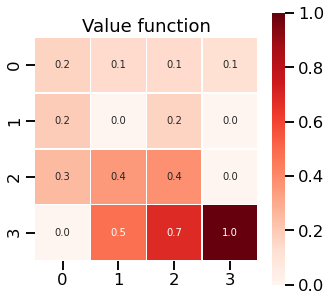

V_array= [0.16632332 0.14305584 0.14316767 0.12305032 0.19431849 0.
 0.16635195 0.         0.2538676  0.35408887 0.38229736 0.
 0.         0.48230117 0.68688647 1.        ]


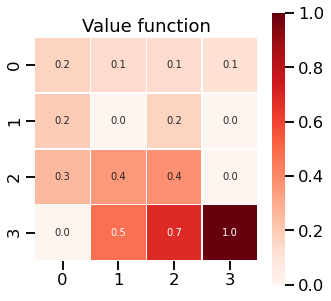

V_array= [0.16687229 0.14348034 0.14344999 0.1233577  0.19476849 0.
 0.16648666 0.         0.25419624 0.35428501 0.38242508 0.
 0.         0.48243301 0.68695117 1.        ]


In [85]:
v_array = value_iteration(gamma=0.95, epsilon=0.01,display=True)
#states_display(v_array, title="Value function", cbar=True, cmap="Reds")

### Display the evolution of the value function over iterations

By running the next cell, we plot out the evolution of `v_array` (the estimated value of each state) over iterations (one curve per state):

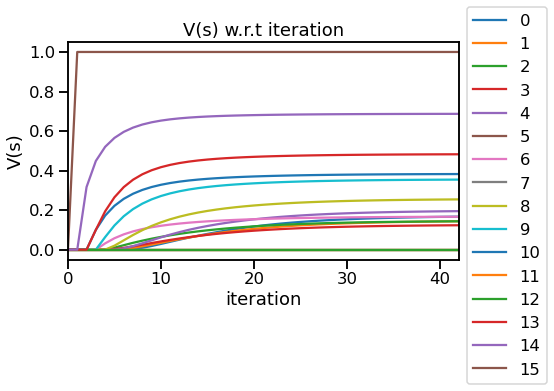

In [86]:
df_v_hist = pd.DataFrame(value_function_history)
df_v_hist.plot(figsize=(7,4))
plt.title("V(s) w.r.t iteration")
plt.ylabel("V(s)")
plt.xlabel("iteration")
plt.legend(bbox_to_anchor=(1,1.2));

Evolution of `delta` over iterations:

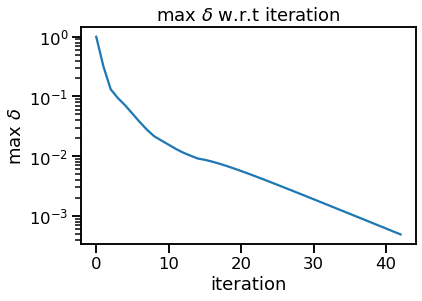

In [87]:
plt.plot(delta_history)
plt.yscale("log")
plt.title(r"$\max~\delta$ w.r.t iteration")
plt.ylabel(r"$\max~\delta$")
plt.xlabel("iteration");

### Question 2: Define the greedy policy (Maximum Expected Utility)

 Finding the Policy that, at each state $\state$, choose the action that maximize ``` expected_value(s, action, v_array)```

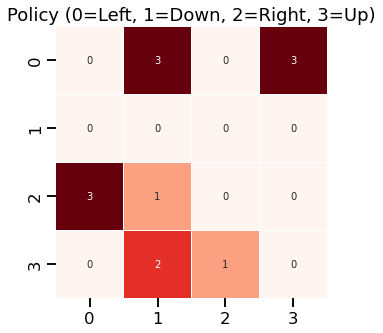

In [88]:
def greedy_policy(state, v_array):

     
    policy = np.argmax(expected_values(state, v_array))


    # Need to return a |S|-dimensional vector called policy where policy[s] represents the optimal action (w.r.t v_array) at state s
    
    return policy


####### Now, we run the function defined above to find the greedy_policy and assign it as 

policy = [greedy_policy(state, v_array) for state in states]

#### Display the greedy policy:
display_policy(policy)

### Evaluate your Value Iteration

(3.1.) We use the syntax in the next cell to get a realization of reward when one runs the ```policy``` obtained above.


**Notes**: Recall that FrozenLake is a stochastic environment, so each time the learning agent runs a policy (even if it is deterministic), the reward is randomized. Run the next cell several time to demonstrate this. 

In [89]:
done = False   #Initial the condition that we are not on a terminate state
state = env.reset()     # Reset the state to 0

while not done:
  #print('current_state=', state) # This should be remove
  action = greedy_policy(state, v_array)
  state, reward, done, info = env.step(action)
  
print('Reward = ', reward)

Reward =  1.0


To measure the performance of our value function ```v_array```, we should assess it several times and count the number of successful trials.
OpenAI considers an agent to successfully solve the FrozenLake problem if it reaches 76% success rate over the last 100 trials (or "episodes").

### Question 4: 

* (4.1) Run the next cell to measure the performance of your ```v_array``` (that is run with epsilon = 0.1). Did you reach the 76% success rate? 

* (4.2) Return to the cell above to re-train your learning agent with smaller epsilon. Re-measure the performance with this new ```v_array```. What is your conclusion on the trade-off of elapsed time and the success rate?

In [95]:
env._max_episode_steps = 1000
reward_list = []
NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state = env.reset()
    done = False
    #t = 0

    while not done:
        action = greedy_policy(state, v_array)
        state, reward, done, info = env.step(action)
        #t += 1

    reward_list.append(reward)
    #print("Episode finished after {} timesteps ; reward = {}".format(t, reward))

print(sum(reward_list) / NUM_EPISODES)            

env.close()

0.792


### Question 5:  In general, what is the discout factor $\gamma$ is for? 
Specifically, what is the intuition when $\gamma = 0$? When $\gamma$ approaches 1?


By running the next cell, we plot out the success rate of the Greedy_policy with respect to a range of different discount factor $\gamma$:

In [ ]:
%%time

NUM_EPISODES = 1000

reward_list = []

for gamma in (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 0.95, 0.99):
    v_array = value_iteration(gamma=gamma)
    
    for episode_index in range(NUM_EPISODES):
        state = env.reset()
        done = False

        while not done:
            action = greedy_policy(state, v_array)
            state, reward, done, info = env.step(action)

        reward_list.append({"gamma": gamma, "reward": reward})

env.close()
df = pd.DataFrame(reward_list)
print(df.tail())
# Plot mean reward (with its 95% confidence interval)

sns.relplot(x="gamma", y="reward", kind="line", data=df, height=6, aspect=1.5)
plt.axhline(0.76, color="red", linestyle=":", label="76% success threshold");   # 76% success threshold
plt.legend();

### Display the Value Iteration optimal policy with respect to $\gamma$:
By running the next cell, we display the optimal policy with respect to different values of $\gamma$. Do they coincide with your intuition for question 5?

In [ ]:
for gamma in (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 0.95, 0.99):
    print()
    print("=" * 10, "GAMMA = ", gamma, "=" * 10)
    print()
    
    v_array = value_iteration(gamma=gamma)
    
    print()
    print()
    
    policy = [greedy_policy(state, v_array) for state in states]
    display_policy(policy)

## Exercise 2 (Homework?): The Policy Iteration algorithm

### Policy Iteration

*Policy Iteration* **[HOWARD60]** is another popular Dynamic Programming algorithm to
compute MDP's optimal policy. In practice, it is often faster than Value Iteration.

The Policy Iteration algorithm alternates the following two steps, starting with an initial policy $\pi_0$:
1. **Policy Evaluation**: given a policy $\pi_i$, compute $\U^{\pi_i}(\state), \forall \state \in \stateset$=the expected value of each state when $\pi_i$ is followed.
2. **Policy Improvement**: compute a new policy $\pi_{i+1}$, using one-step look-ahead based on $\U^{\pi_i}$ and using the principle of *Maximum Expected Utility* as follows
$$
\policy_{\iterationindex+1}(\state) = \arg \max_{\action \in \actionspace} \sum_{\nextstate  \in \statespace} \transitionfuncinst \left( \rewardfuncinst + \discount \valuefunc^{\policy_{\iterationindex}}(\nextstate) \right)
$$

In the following exercise, since we work with the FrozenLake environment, we will assume that the reward only depends on the state: $r(\state) \equiv \mathcal{R}(\state, \action, \state')$.
Thus the *Policy Improvement* can be rewritten as follow:

$$
\pi_{i+1}(\state) = \arg\max_{\action \in \actionset} \sum_{\state' \in \stateset} P(\state' | \state, \action) \U^{\pi_i}(\state')$$

($\rewardfunc$ and $\discount$ can disappear as they have no influence on the $\arg\max_{\action}$ result).

Algorithm 3 describes the two-step procedure.
The algorithm terminates when the *Policy Improvement* step yields no change in the utilities.

___
### Algorithm 3: Policy Iteration

**Input**:<br>
$\quad$ $MDP = \langle \stateset, \actionset, T, r \rangle$, a Markov Decision Process<br>
**Local variables**: <br>
$\quad$ $\U$, vector of utilities for states in $\stateset$, initially zero <br>
$\quad$ $\pi$, a policy vector indexed by state, initially random <br>
<br>
**repeat** <br>
$\quad$ $\valuefunc \leftarrow \text{POLICY-EVALUATION}(\policy, \valuefunc, \mdp)$ <br>
$\quad$ **for all** $\mbox{state} ~ \state \in \stateset$ **do** <br>
$\quad\quad\quad$ $\displaystyle \pi[\state] \leftarrow \arg\max_{\action \in \actionset} \left[ \sum_{\state' \in \stateset} \transitionfuncinst \U[\state'] \right]$ <br>
$\quad$ **end for** <br>
**until** unchanged (stopping criterior) <br>
<br>
**return** $\pi$
___

###  POLICY-EVALUATION:

* Similar to what we see in Value Iteration, when given a policy $\policy_i$, we can express the value $\U^{\policy_i}(s)$ via the Bellman-equation as follows:
\begin{equation}
    \U^{\pi_i}(\state) = \left\{
    \begin{array}{l l}
        r(\state)               & \quad \text{if $\state$ is a final state} \\
        \displaystyle r(\state) + \discount \sum_{\nextstate \in \statespace} \transitionfunc(\nextstate | \state, \policy_{\iterationindex}(\state)) ~ \valuefunc^{\policy_{\iterationindex}}(\nextstate)     & \quad \text{otherwise}\\
    \end{array} \right.
\end{equation}


* There are two ways to compute $\U^{\policy_i}(s)$:
  * In large-size problems: Estimation via **Iterative Policy-Iteration**: Initialize at $\U^{\policy_i}(s) = 0, \forall s$, repeatedly run Bellman-update until reach a certain stopping criterion.
  * In small-size problems: Compute exactly $\U^{\policy_i}$ via **Linear Programmming**:
  $$ 
  \begin{bmatrix}
  1 - \prob(s_1|s_1, \policy_{i}(s_1)) & -\gamma \prob(s_2|s_1, \policy_{i}(s_1))& ... & -\gamma \prob(s_{|S|}|s_1, \policy_{i}(s_1))\\ 
  -\gamma \prob(s_1|s_2, \policy_{i}(s_2)) & 1-\gamma \prob(s_2|s_2, \policy_{i}(s_2))& ... & -\gamma \prob(s_{|S|}|s_2, \policy_{i}(s_2))\\
  ...\\
  -\gamma \prob(s_1|s_{|S|}, \policy_{i}(s_{|S|})) & -\gamma \prob(s_2|s_{|S|}, \policy_{i}(s_{|S|}))& ... & 1-\gamma \prob(s_{|S|}|s_{|S|}, \policy_{i}(s_{|S|}))
  \end{bmatrix} \cdot
  \begin{bmatrix}
  \U^{\policy_i}(s_1) \\ 
  \U^{\policy_i}(s_2)\\
  ...\\
  \U^{\policy_i}(s_{|S|})
  \end{bmatrix}  = \begin{bmatrix}
  R(s_1) \\ 
  R(s_2)\\
  ...\\
  R(s_{|S|})
  \end{bmatrix} 
$$
Therefore, call the matrix in the left-hand-side as $A$, we have: 
$$ \U^{\policy_i} = A^{-1} \cdot R $$

### Question 1: Define the (exact) Policy Evaluation function

In this lab, since FrozenLake is relatively small, we will solve Policy Evaluation via Linear Programming. 

In the next cell, given a policy and a discount factor $\gamma$, you need to compute the matrix A; then, return the vector $V$.

**Hints**:  It is convenient to use the matrices operations of numpy such as ```np.linalg.inv(A)```, ```np.dot```, ```np.matmul```.

In [170]:
def policy_evaluation(policy, gamma):

    A = np.full(shape=(len(states), len(states)), fill_value=np.nan)
    v =  np.zeros(len(states))
    
   ##### FILLLING IN THE BLANK HERE: YOU NEED TO COMPUTE THE MATRIX A
   
    for s in states: 
        A[s] = -gamma*transition_array[s, policy[s],:] 
        
    
    np.fill_diagonal(A,1+np.diag(A))
       
    v = np.dot(np.linalg.inv(A), reward_array)
   
 
    return v

In [171]:
#Test
policy = np.random.randint(low=min(actions), high=max(actions), size=len(states), dtype='int')  # Random initial policy

policy_evaluation(policy, gamma=0.99)


array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 100.])

### Question 2: Define the Policy Improvement function

In the next-cell, we code the Policy Iteration Algorithm. 

Note that we use the stopping criterio: if $\policy_{k+1} =  \policy_{k}$, we stop. 

In [172]:
def policy_iteration(gamma, initial_policy=None, policy_evaluation_function=policy_evaluation):

    
    # Set the initial policy either by manually chosen or by randomized:
    if initial_policy is not None:
        policy = initial_policy
    else: policy = np.random.randint(low=min(actions), high=max(actions), size=len(states), dtype='int')  # Random initial policy

    
    stop = False  #Initialize for stopping criterior
    while not stop:
        #FILLLING IN THE BLANK HERE:...........
        
        # FIRST, YOU NEED TO EVALUATE THE CURRENT POLICY ( via policy-evaluation defined above)
        v_array = policy_evaluation_function(policy, gamma)
        
        last_policy = policy.copy()

        #SECOND, YOU NEED TO UPDATE THE NEW POLICY VIA GREEDY (i.e., Policy Improvement, see theory in above cells )
        policy =  [greedy_policy(s, v_array) for s in states]
        
        # THIRD, YOU NEED TO CHECK THE STOPPING CRITERIOR:
        if np.array_equal(policy, last_policy):
            stop = True
        
    return policy

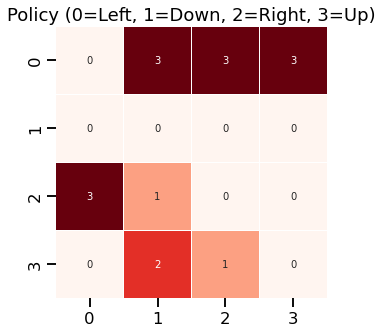

In [173]:
######### Now, we can test by running policy iteration and assign the output to policy:

gamma = 0.99
    
policy = policy_iteration(gamma=gamma, policy_evaluation_function=policy_evaluation)
display_policy(policy)



### Evaluate Policy Iteration for different $\gamma$ with confidence interval (bootstrap)
Run the next cell to evaluate perfirmance of Policy Iteration with several $\gamma$:

      gamma  reward
9995   0.99     1.0
9996   0.99     1.0
9997   0.99     1.0
9998   0.99     0.0
9999   0.99     1.0


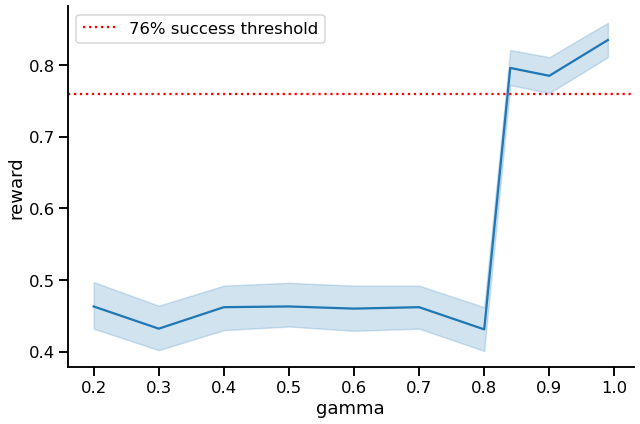

Wall time: 3.23 s


In [174]:
%%time

NUM_EPISODES = 1000

reward_list = []

for gamma in (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 0.99):
    # print("gamma:", gamma)
    policy = policy_iteration(gamma=gamma)
    
    for episode_index in range(NUM_EPISODES):
        state = env.reset()
        done = False

        while not done:
            action = policy[state]
            state, reward, done, info = env.step(action)

        reward_list.append({"gamma": gamma, "reward": reward})

env.close()
df = pd.DataFrame(reward_list)
print(df.tail())

sns.relplot(x="gamma", y="reward", kind="line", data=df, height=6, aspect=1.5)
plt.axhline(0.76, color="red", linestyle=":", label="76% success threshold");   # 76% success threshold
plt.legend()
plt.show()